# Analyze correlations in the snow cover time series data

In [1]:
# Install packages not in the default Colab environment
!pip install rioxarray

In [17]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# If using Google Colab, mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define path settings, load functions

In [4]:
# define path to study-sites/
study_sites_path = '/content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites'

# define path to snow-cover-mapping-application/
base_path = os.path.join(study_sites_path, '..', 'snow-cover-mapping-application')

# determine whether to save figures to file
save_figures = True

# path to save output figures
figures_out_path = os.path.join(base_path, 'figures')

# Load necessary functions
sys.path.insert(1, os.path.join(base_path, 'functions'))
import model_analyze_utils as f

## Load compiled snow cover statistics

In [5]:
data_path = os.path.join(study_sites_path, '..', 'snow-cover-mapping-application', 'inputs-outputs')
data_fn = 'snowline_timeseries_full_training_data_OLD.csv'
data_df = pd.read_csv(os.path.join(data_path, data_fn))
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df

,site_name,Date,AAR,ELA_from_AAR_m,Cumulative_Positive_Degree_Days,Cumulative_Snowfall_mwe,Mean_Annual_Air_Temp_Range,Mean_Annual_Precipitation_Max,PA_Ratio,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Hypsometric_Index,Hypsometric_Index_Category
0,Blue,2013-09-12,0.437856,1970.00,1083.073924,2.063305,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
1,Blue,2013-09-19,0.447500,1954.96,1145.346363,2.086689,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
2,Blue,2013-10-14,0.817829,1591.00,1194.868455,0.062328,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
3,Blue,2014-05-01,0.925804,1481.00,30.896912,1.545164,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
4,Blue,2014-06-02,0.893074,1526.00,164.490870,1.694039,32.406671,2.168887,8.141722,2.0,4.0,5.663,1252,2371,1880,17.7,19,-1.256000,Top heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49809,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy
49810,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy
49811,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy
49812,RGI60-02.17738,2021-08-18,0.584552,2193.00,832.630152,1.412379,40.852038,1.505997,8.708201,2.0,2.0,7.082,1770,2626,2257,17.9,329,-1.229219,Top heavy


## Determine unique subregions

In [6]:
# -----Display unique subregions and number in each
data_df[['O1Region', 'O2Region']] = data_df[['O1Region', 'O2Region']].astype(float)
data_df = data_df.sort_values(by=['O1Region', 'O2Region', 'site_name', 'Date']).reset_index(drop=True)
unique_subregion_counts = data_df[['O1Region', 'O2Region']].value_counts().reset_index(name='count')
unique_subregion_counts = unique_subregion_counts.sort_values(by=['O1Region', 'O2Region']).reset_index(drop=True)
# grab unique subregions
unique_subregions = unique_subregion_counts[['O1Region', 'O2Region']].values
unique_subregion_counts

,O1Region,O2Region,count
0,1.0,2.0,6869
1,1.0,3.0,4704
2,1.0,4.0,4991
3,1.0,5.0,6881
4,1.0,6.0,6083
5,2.0,1.0,2942
6,2.0,2.0,6605
7,2.0,3.0,3882
8,2.0,4.0,4449
9,2.0,5.0,2408


## Calculate correlation coefficients for time series variables between sites in each subregion

Alaska Range
Number of sites = 26


  0%|          | 0/26 [00:00<?, ?it/s]

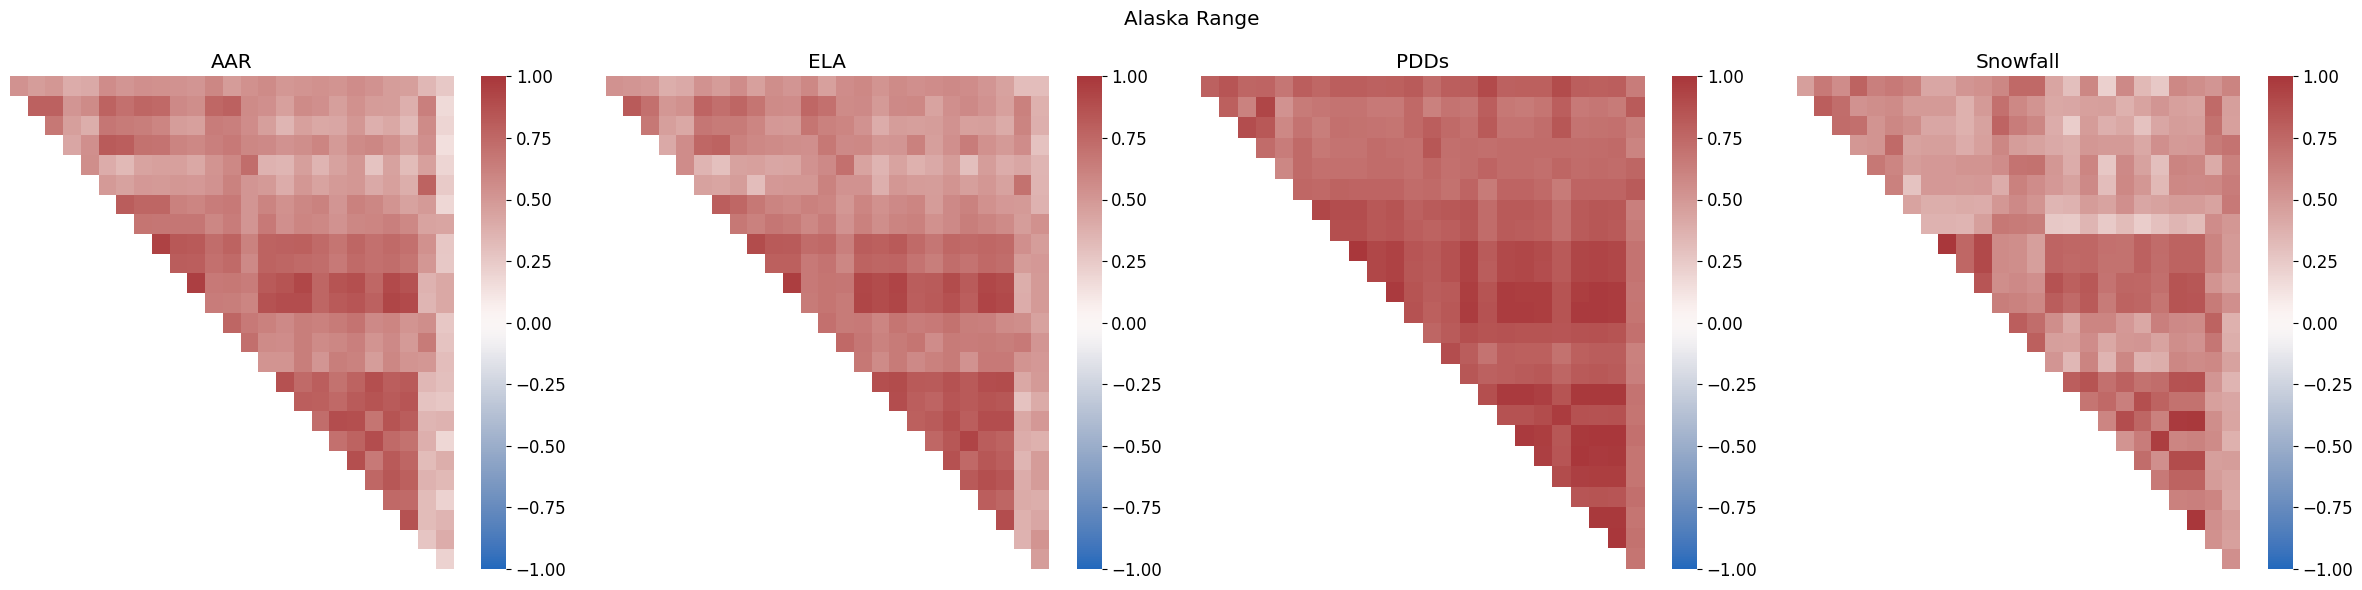

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_Alaska Range.png
 
Aleutians
Number of sites = 28


  0%|          | 0/28 [00:00<?, ?it/s]

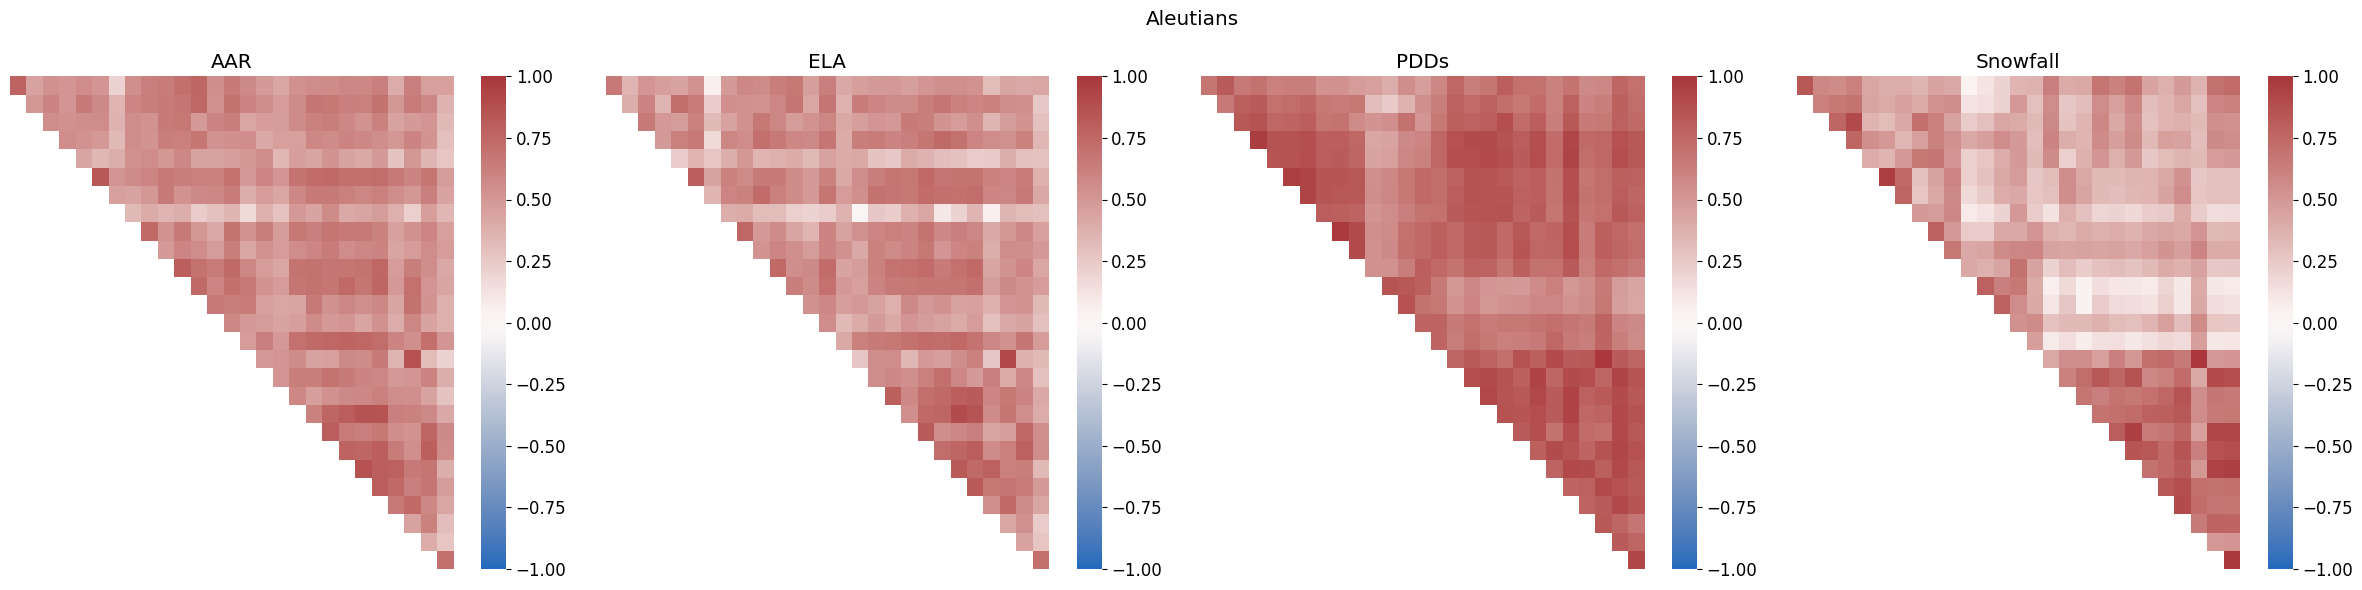

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_Aleutians.png
 
W. Chugach Mtns.
Number of sites = 17


  0%|          | 0/17 [00:00<?, ?it/s]

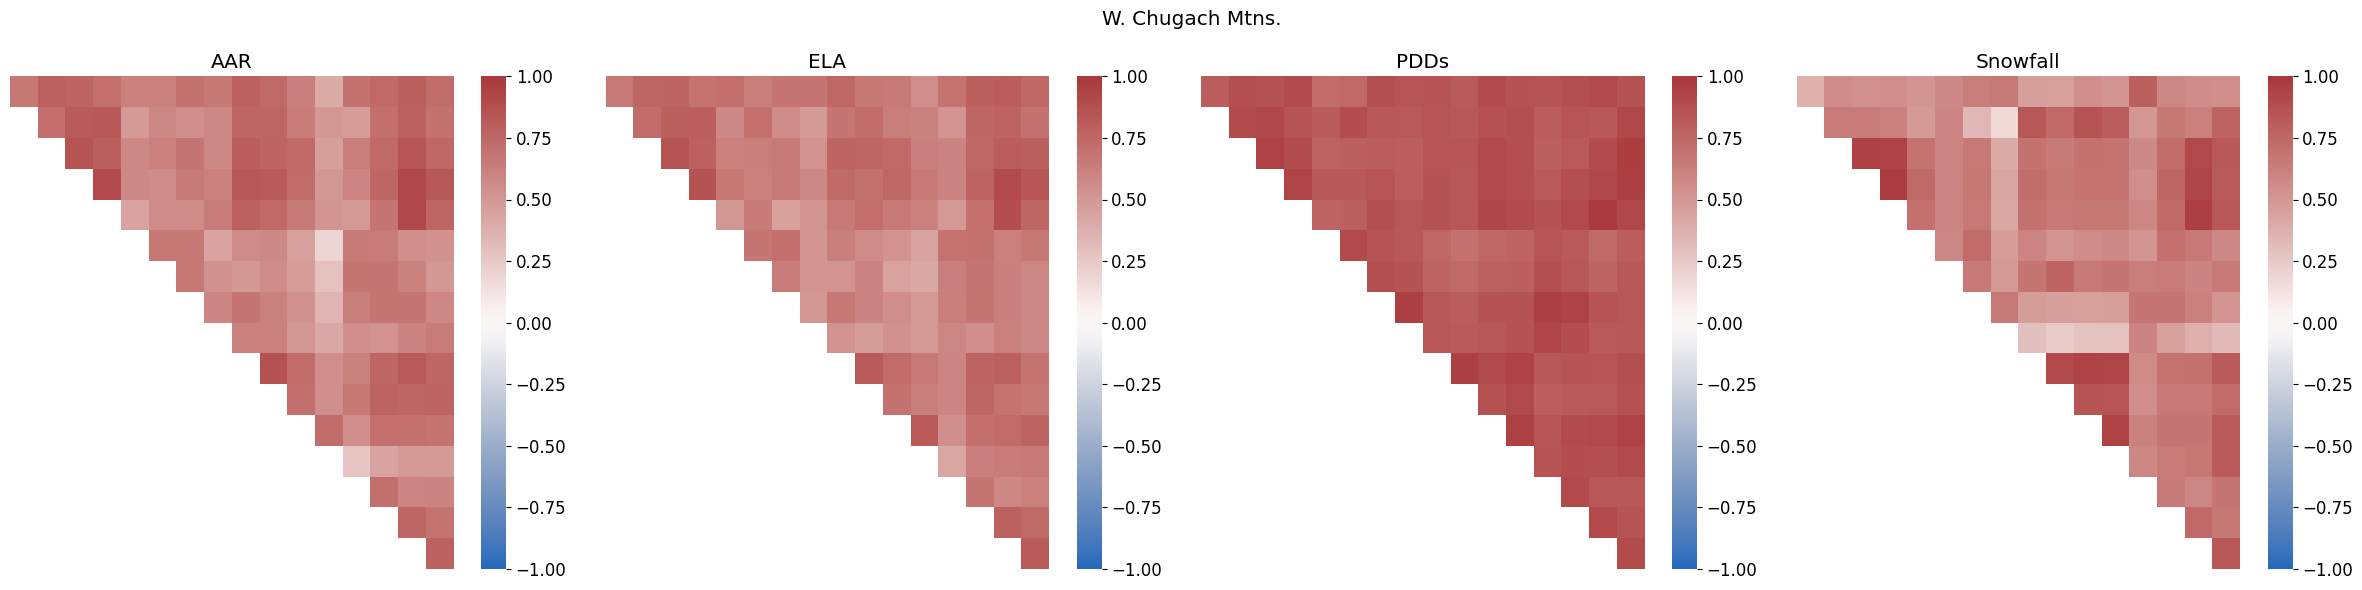

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_W. Chugach Mtns..png
 
St. Elias Mtns.
Number of sites = 24


  0%|          | 0/24 [00:00<?, ?it/s]

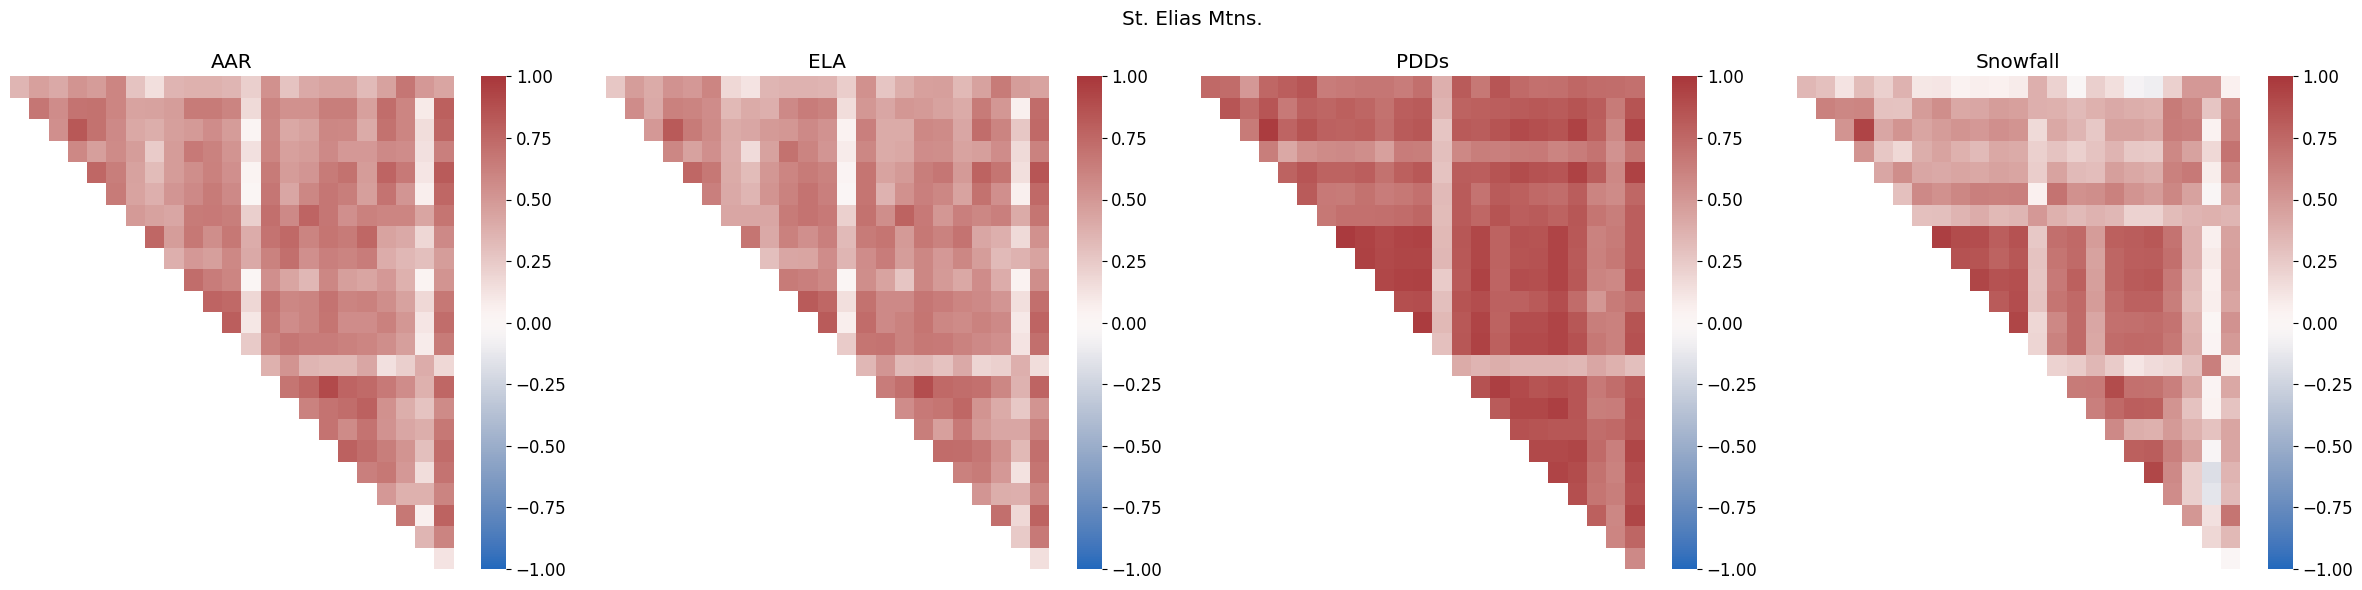

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_St. Elias Mtns..png
 
N. Coast Ranges
Number of sites = 27


  0%|          | 0/27 [00:00<?, ?it/s]

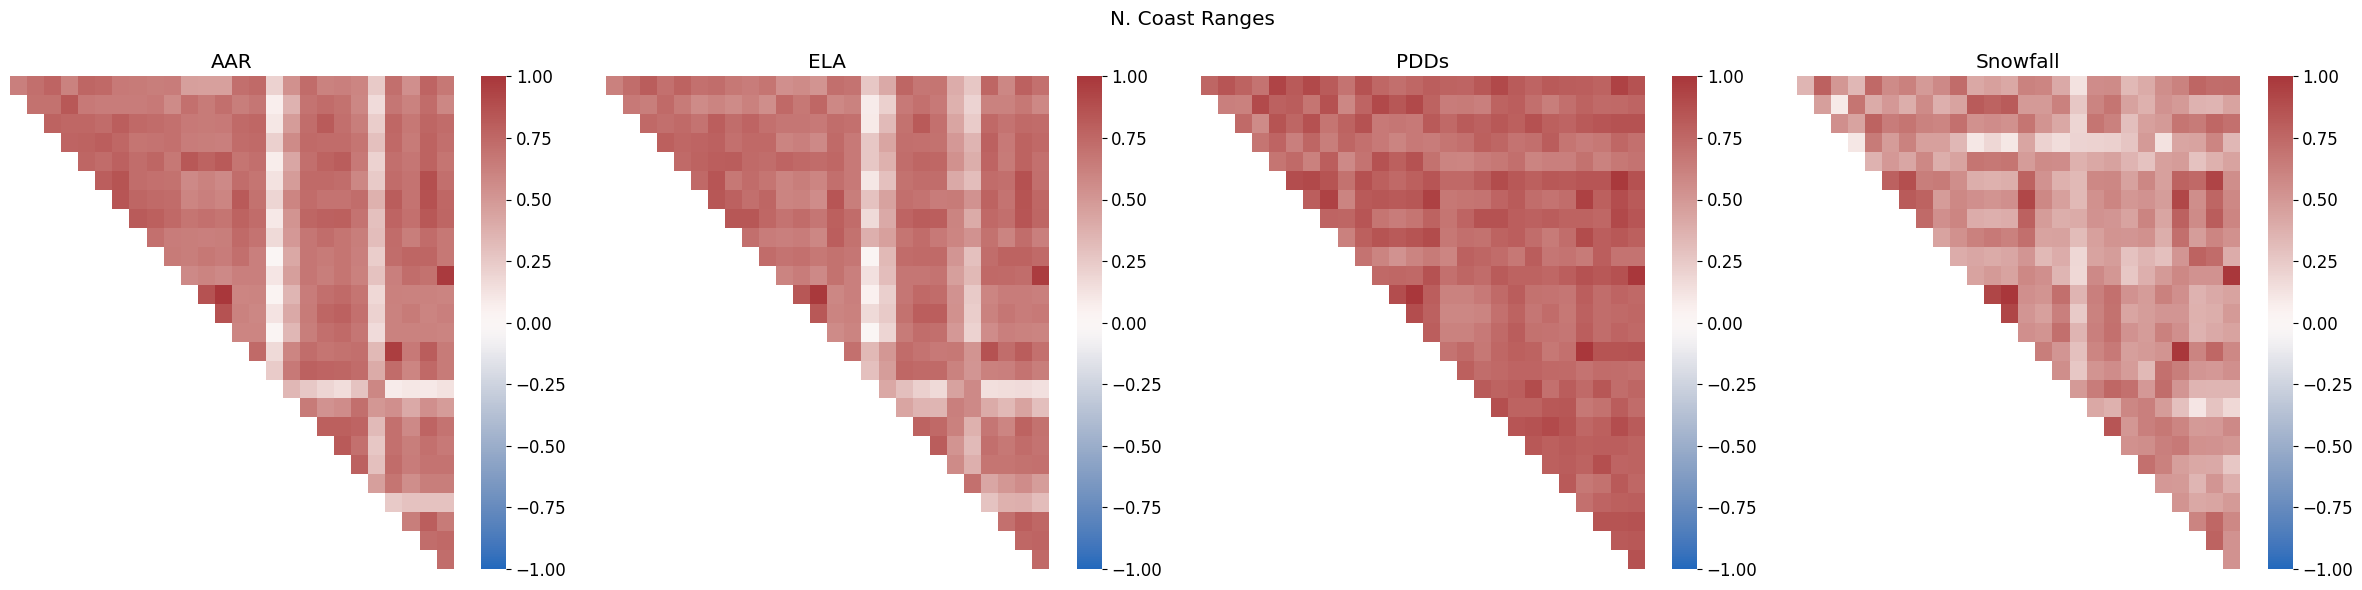

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_N. Coast Ranges.png
 
N. Rockies
Number of sites = 12


  0%|          | 0/12 [00:00<?, ?it/s]

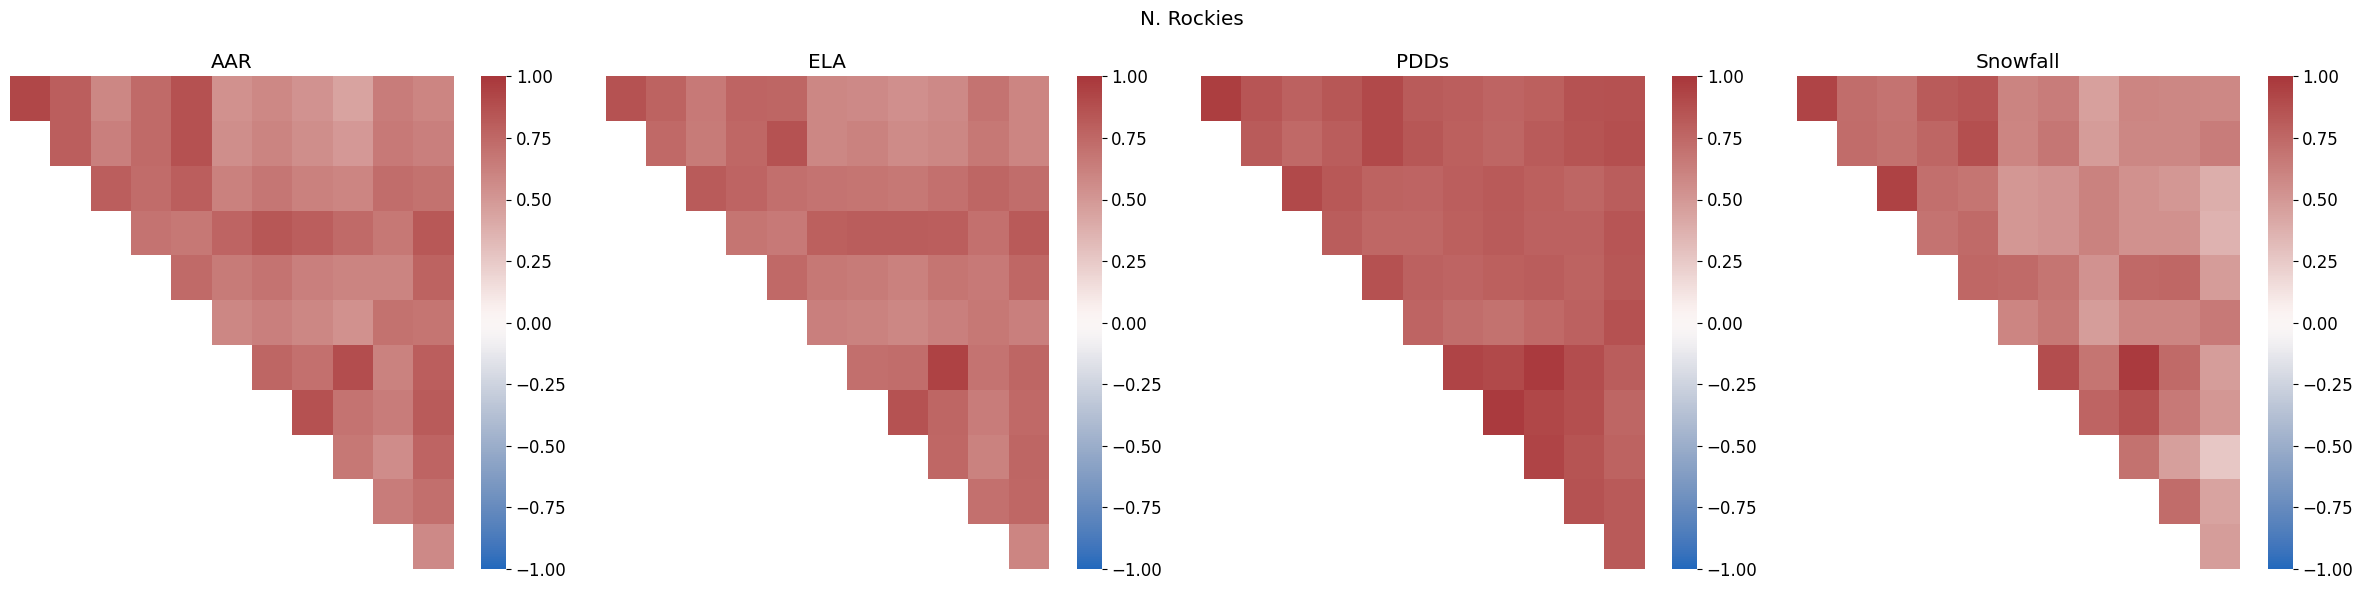

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_N. Rockies.png
 
N. Cascades
Number of sites = 18


  0%|          | 0/18 [00:00<?, ?it/s]

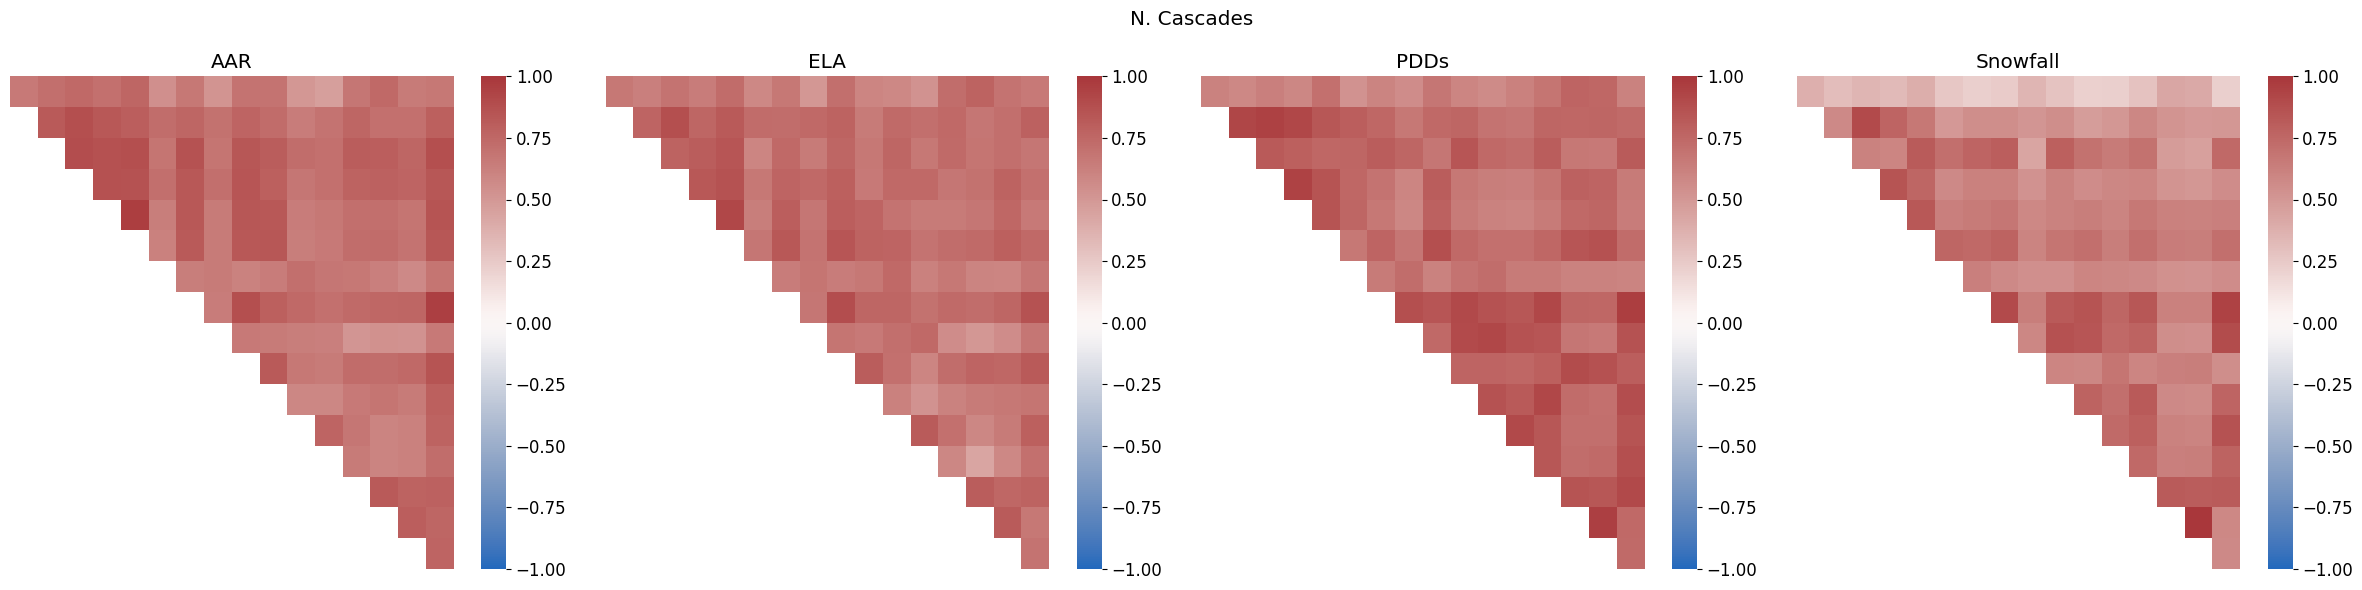

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_N. Cascades.png
 
C. Rockies
Number of sites = 15


  0%|          | 0/15 [00:00<?, ?it/s]

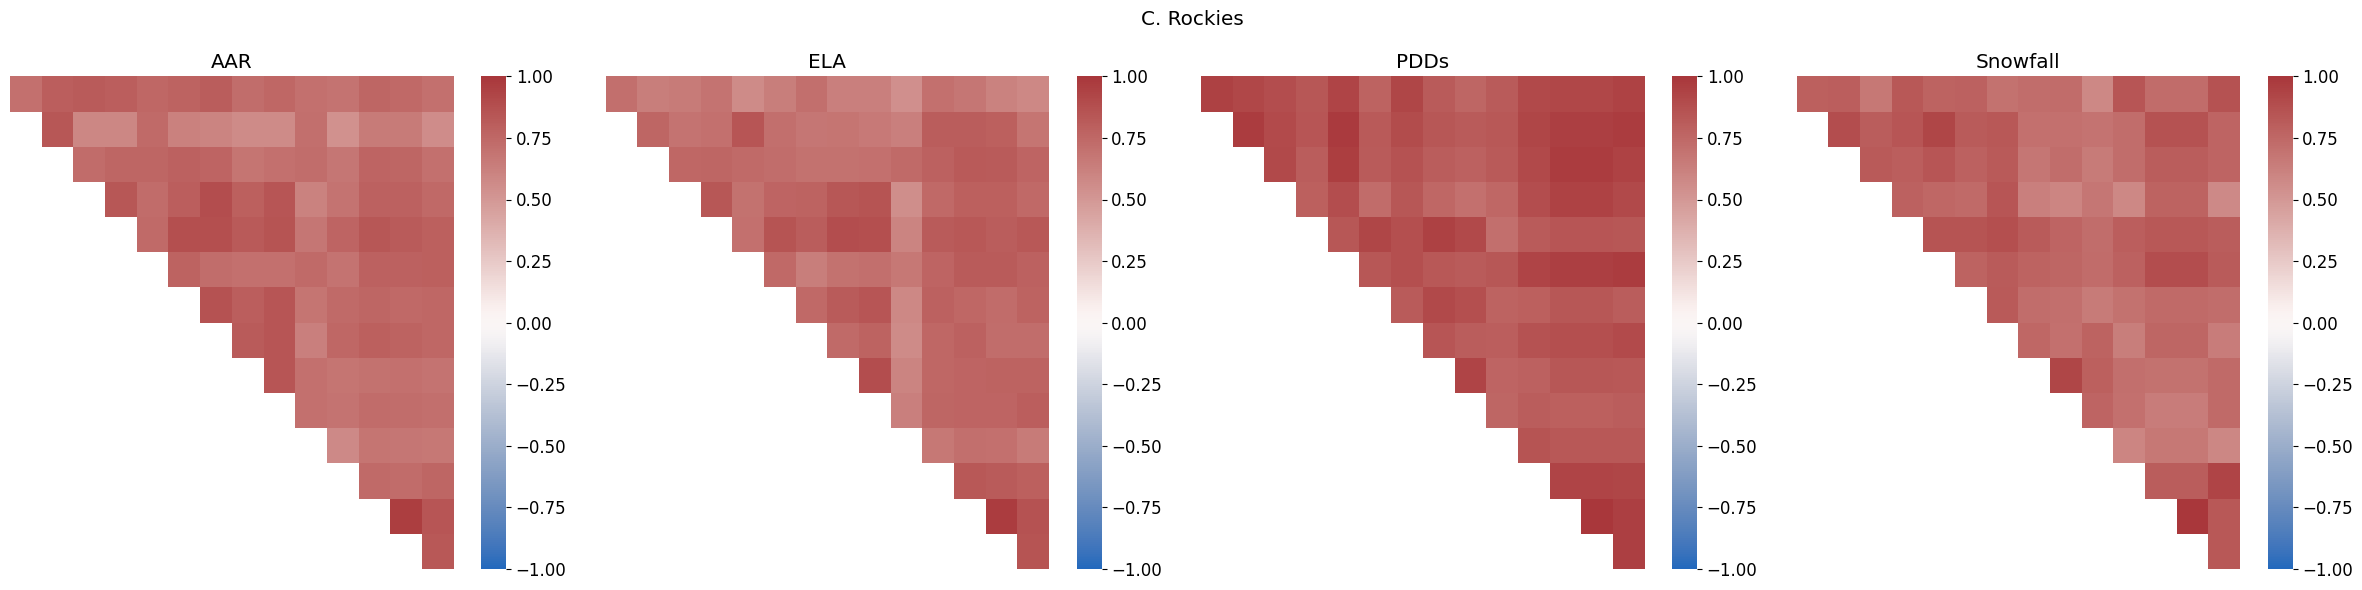

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_C. Rockies.png
 
S. Cascades
Number of sites = 9


  0%|          | 0/9 [00:00<?, ?it/s]

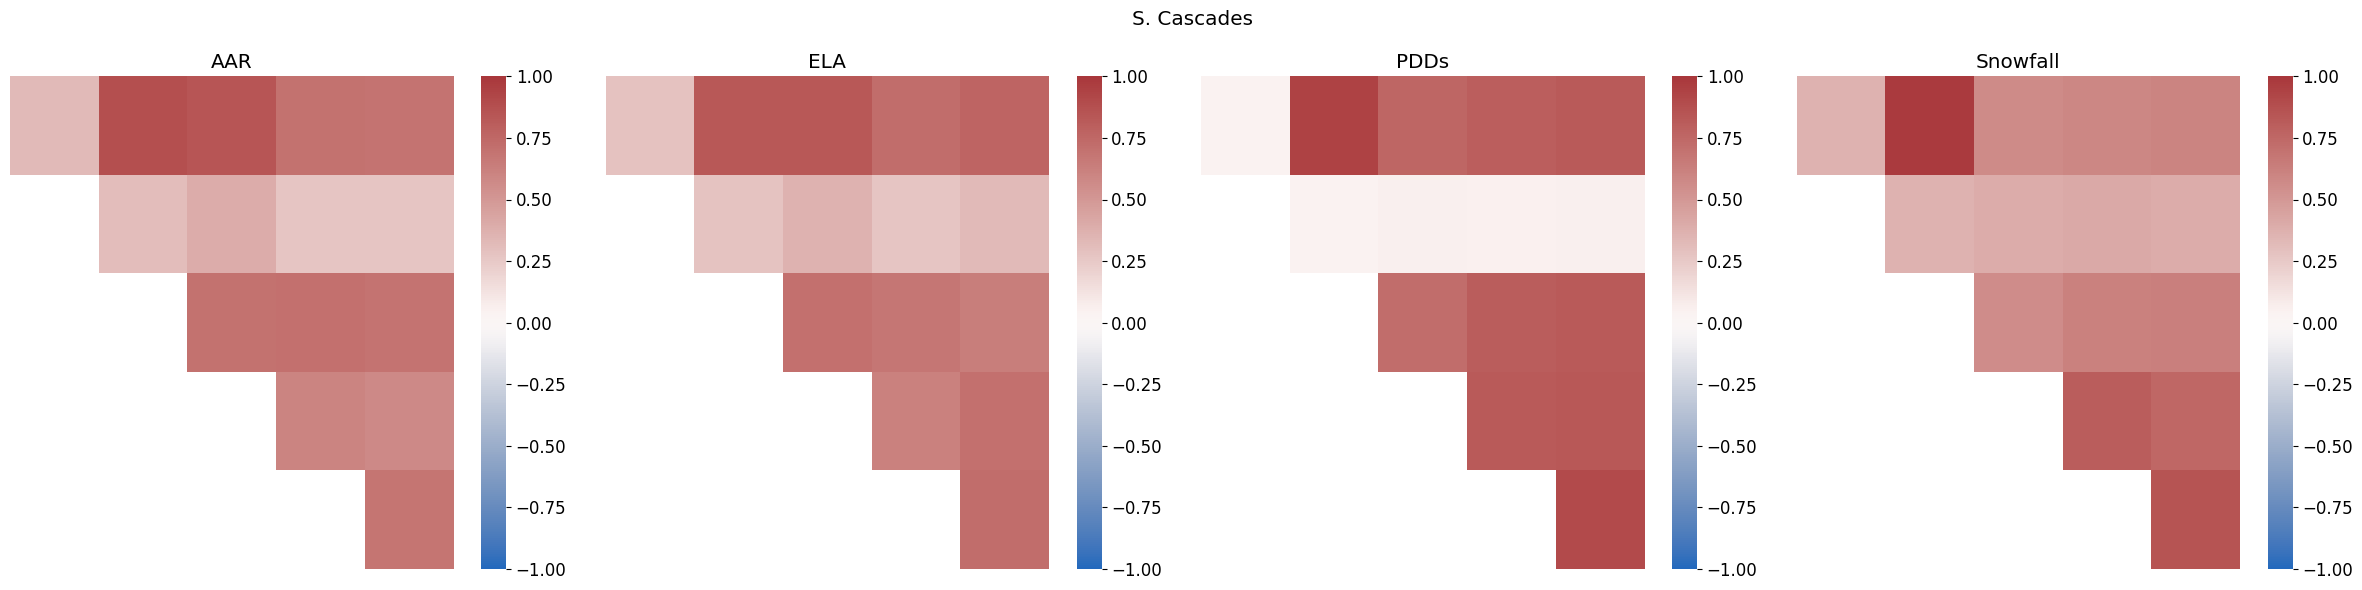

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_S. Cascades.png
 
S. Rockies
Number of sites = 8


  0%|          | 0/8 [00:00<?, ?it/s]

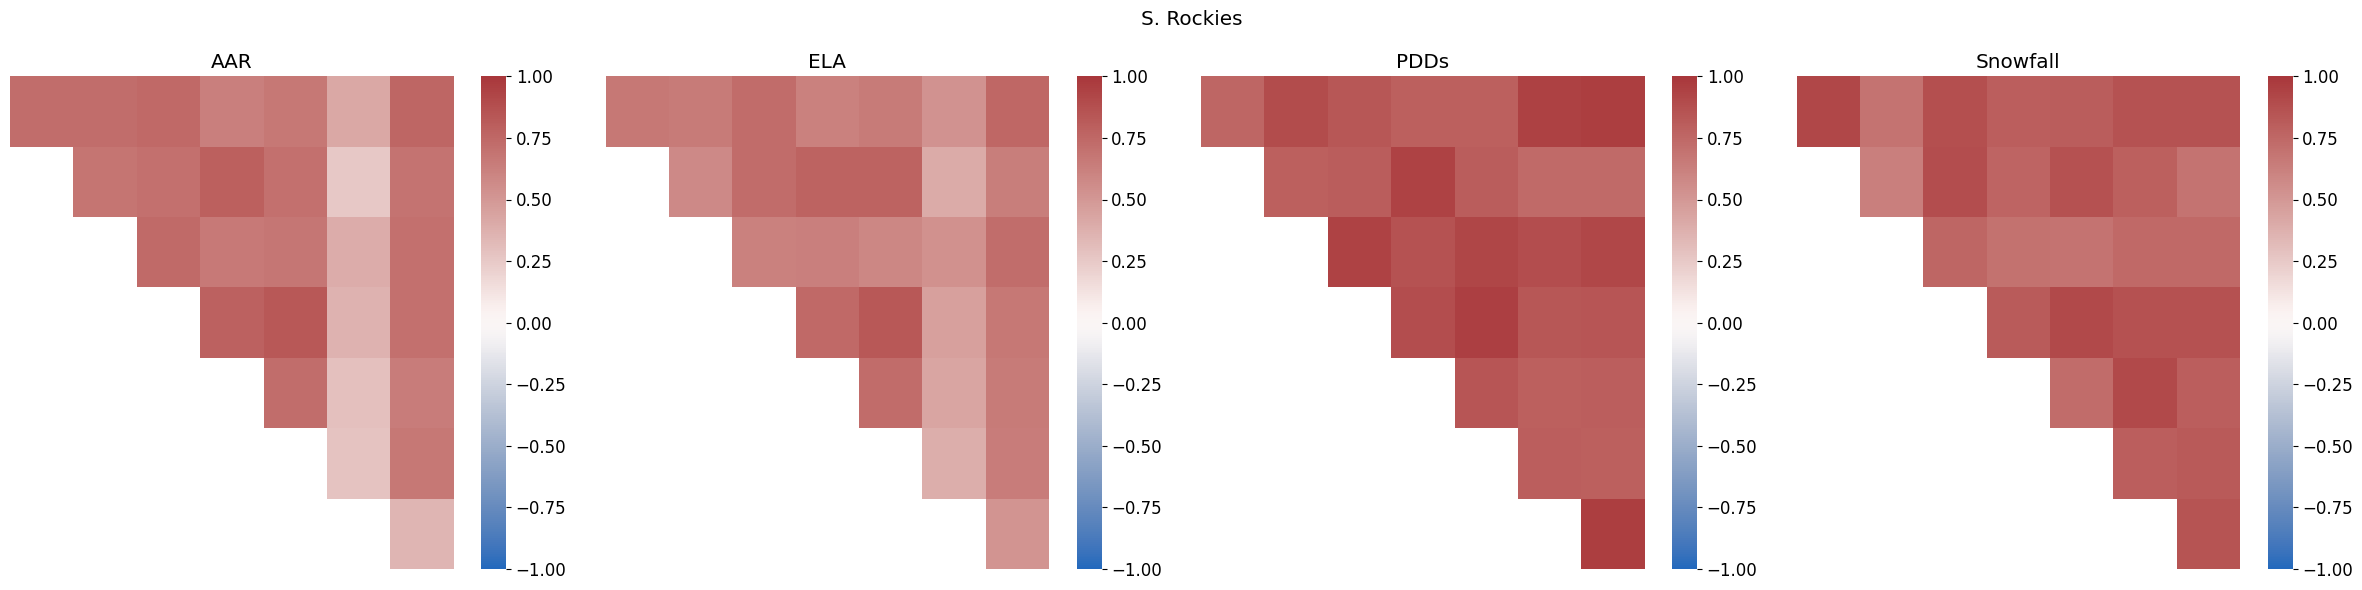

figure 1 saved to file: /content/drive/MyDrive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/../snow-cover-mapping-application/figures/corrcoeffs_heatmap_S. Rockies.png
 


In [15]:
# -----For individual subregions
correlation_sites_df = pd.DataFrame()
plt.rcParams.update({'font.size':12})
cmap = "vlag"
data_df.index = data_df['Date']

for o1region, o2region in unique_subregions:

    # determine name of subregion
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    print(subregion_name)

    # subset data to sites in subregion
    data_subregion_df = data_df.loc[(data_df['O1Region']==o1region) & (data_df['O2Region']==o2region)]

    # grab list of site names in subregion
    site_names_subregion = sorted(data_subregion_df['site_name'].drop_duplicates().values)
    print('Number of sites = ' + str(len(site_names_subregion)))

    correlation_subregion = []
    for i in tqdm(range(0, len(site_names_subregion))):

        site1_df = data_subregion_df.loc[data_subregion_df['site_name']==site_names_subregion[i]]
        site1_df = site1_df[~site1_df.index.duplicated(keep='first')].sort_index()  # remove duplicate dates, sort by date

        for j in range(i+1, len(site_names_subregion)):

            site2_df = data_subregion_df.loc[data_subregion_df['site_name']==site_names_subregion[j]]
            site2_df = site2_df[~site2_df.index.duplicated(keep='first')].sort_index()  # remove duplicate dates, sort by date

            # resample both dataframes at a daily time interval
            site1_df = site1_df.resample('1D').bfill()
            site2_df = site2_df.resample('1D').bfill()
            min_date = np.min([site1_df.iloc[0]['Date'], site2_df.iloc[0]['Date']])
            max_date = np.max([site1_df.iloc[-1]['Date'], site2_df.iloc[-1]['Date']])
            site1_df = site1_df.loc[(site1_df['Date'] >= min_date) & (site1_df['Date'] <= max_date)]
            site2_df = site2_df.loc[(site2_df['Date'] >= min_date) & (site2_df['Date'] <= max_date)]

            # calculate correlation coefficient
            aar_correlation = pd.DataFrame({'Site1': site1_df['AAR'],
                                            'Site2': site2_df['AAR']}).corr().iloc[0,1]
            ela_correlation = pd.DataFrame({'Site1': site1_df['ELA_from_AAR_m'],
                                            'Site2': site2_df['ELA_from_AAR_m']}).corr().iloc[0,1]
            pdd_correlation = pd.DataFrame({'Site1': site1_df['Cumulative_Positive_Degree_Days'],
                                            'Site2': site2_df['Cumulative_Positive_Degree_Days']}).corr().iloc[0,1]
            snowfall_correlation = pd.DataFrame({'Site1': site1_df['Cumulative_Snowfall_mwe'],
                                                 'Site2': site2_df['Cumulative_Snowfall_mwe']}).corr().iloc[0,1]
            correlation_subregion.append({'Site1': site_names_subregion[i],
                                          'Site2': site_names_subregion[j],
                                          'AAR Correlation': aar_correlation,
                                          'ELA Correlation': ela_correlation,
                                          'PDD Correlation': pdd_correlation,
                                          'Snowfall Correlation': snowfall_correlation
                                         })

    # convert list to pandas.DataFrame
    correlation_df = pd.DataFrame(correlation_subregion)
    mean_aar_correlations = correlation_df['AAR Correlation'].dropna().values
    mean_ela_correlations = correlation_df['ELA Correlation'].dropna().values
    mean_pdd_correlations = correlation_df['PDD Correlation'].dropna().values
    mean_snowfall_correlations = correlation_df['Snowfall Correlation'].dropna().values
    # concatenate mean regional statistics with full correlation df
    correlation_mean_df = pd.DataFrame({'Subregion': [subregion_name],
                                        'Mean AAR Correlation': [mean_aar_correlations],
                                        'Mean ELA Correlation': [mean_ela_correlations],
                                        'Mean PDD Correlation': [mean_pdd_correlations],
                                        'Mean Snowfall Correlation': [mean_snowfall_correlations],
                                        'Color': [color]
                                       })
    correlation_df = pd.concat([correlation_df, correlation_mean_df])

    # plot
    # heatmaps
    columns = ['AAR Correlation', 'ELA Correlation', 'PDD Correlation', 'Snowfall Correlation']
    titles = ['AAR', 'ELA', 'PDDs', 'Snowfall']
    fig1, ax1 = plt.subplots(1, len(columns), figsize=(24, 6))
    for axis, column, title in zip(ax1, columns, titles):
        sns.heatmap(correlation_df.pivot_table(index='Site1', columns='Site2', values=column),
                    ax=axis, cmap=cmap, vmin=-1, vmax=1, cbar=True)
        axis.set_title(title)
        axis.set_xlabel('')
        axis.set_ylabel('')
        axis.set_xticks([])
        axis.set_yticks([])
    fig1.suptitle(subregion_name)
    fig1.tight_layout()
    # boxplots
    # correlation_df.reset_index(drop=True, inplace=True)
    # columns = ['Mean AAR Correlation', 'Mean ELA Correlation', 'Mean PDD Correlation', 'Mean Snowfall Correlation']
    # titles = ['AAR', 'ELA', 'PDD', 'Snowfall']
    # fig2, ax2 = plt.subplots(1, len(columns), figsize=(20,6))
    # for i, (column, title) in enumerate(zip(columns, titles)):
    #     bplot = ax2[i].boxplot(correlation_df[column], notch=True,
    #                            bootstrap=1000,
    #                            patch_artist=True,
    #                            labels=correlation_df['Subregion'],
    #                            showfliers=False)
    #     for patch, color in zip(bplot['boxes'], correlation_df['Color'].values):
    #         patch.set_facecolor(color)
    #     for median in bplot['medians']:
    #         median.set_color('white')
    #     ax2[i].set_xticklabels(axis.get_xticklabels(), rotation=90)
    #     ax2[i].grid()
    #     ax2[i].set_ylabel('Pearson correlation coefficient')
    #     ax2[i].set_title(title)
    #     ax2[i].set_ylim(-0.1, 1)
    #     # medians = [median.get_ydata()[0] for median in bplot['medians']]

    plt.show()

    # save figure
    if save_figures:
        fig1_fn = os.path.join(figures_out_path, 'corrcoeffs_heatmap_' + subregion_name + '.png')
        fig1.savefig(fig1_fn, dpi=300, bbox_inches='tight')
        print('figure 1 saved to file: ' + fig1_fn)
        # fig2_fn = os.path.join(figures_out_path, 'corrcoeffs_boxplot_' + subregion_name + '.png')
        # fig2.savefig(fig2_fn, dpi=300, bbox_inches='tight')
        # print('figure 2 saved to file: ' + fig2_fn)
    # print correlation coefficient statistics
    # print('AAR Correlation Coefficients:')
    # print('     Mean = ' + str(np.nanmean(correlation_df.pivot_table(index='Site1', columns='Site2', values='AAR Correlation'))))
    # print('     Std. = ' + str(np.nanstd(correlation_df.pivot_table(index='Site1', columns='Site2', values='AAR Correlation'))))
    # print('     Median = ' + str(np.nanmedian(correlation_df.pivot_table(index='Site1', columns='Site2', values='AAR Correlation'))))
    # print('     MAD = ' + str(median_abs_deviation(np.ravel(correlation_df.pivot_table(index='Site1', columns='Site2', values='AAR Correlation').values),
    #                                                nan_policy='omit')))
    # print('Median Snowline Elevations Correlation Coefficients:')
    # print('     Mean = ' + str(np.nanmean(correlation_df.pivot_table(index='Site1', columns='Site2', values='ELA Correlation'))))
    # print('     Std. = ' + str(np.nanstd(correlation_df.pivot_table(index='Site1', columns='Site2', values='ELA Correlation'))))
    # print('     Median = ' + str(np.nanmedian(correlation_df.pivot_table(index='Site1', columns='Site2', values='ELA Correlation'))))
    # print('     MAD = ' + str(median_abs_deviation(np.ravel(correlation_df.pivot_table(index='Site1', columns='Site2', values='ELA Correlation').values),
    #                                                nan_policy='omit')))
    print(' ')



## Calculate correlation coefficients between AAR/ELA and weather time series

In [ ]:
# Define predictor columns
X_columns = ['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']

# Iterate over subregions
for i, (o1region, o2region) in enumerate(unique_subregions):

    # determine name of subregion
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    print(subregion_name)

    # subset data to sites in subregion
    data_subregion_df = data_df.loc[(data_df['O1Region']==o1region) & (data_df['O2Region']==o2region)]


## Conduct Principal Components Analysis within each subregion to analyze which parameters best explain the variance in the input data

Alaska Range
Aleutians
W. Chugach Mtns.
St. Elias Mtns.
N. Coast Ranges
N. Rockies
N. Cascades
C. Rockies
S. Cascades
S. Rockies


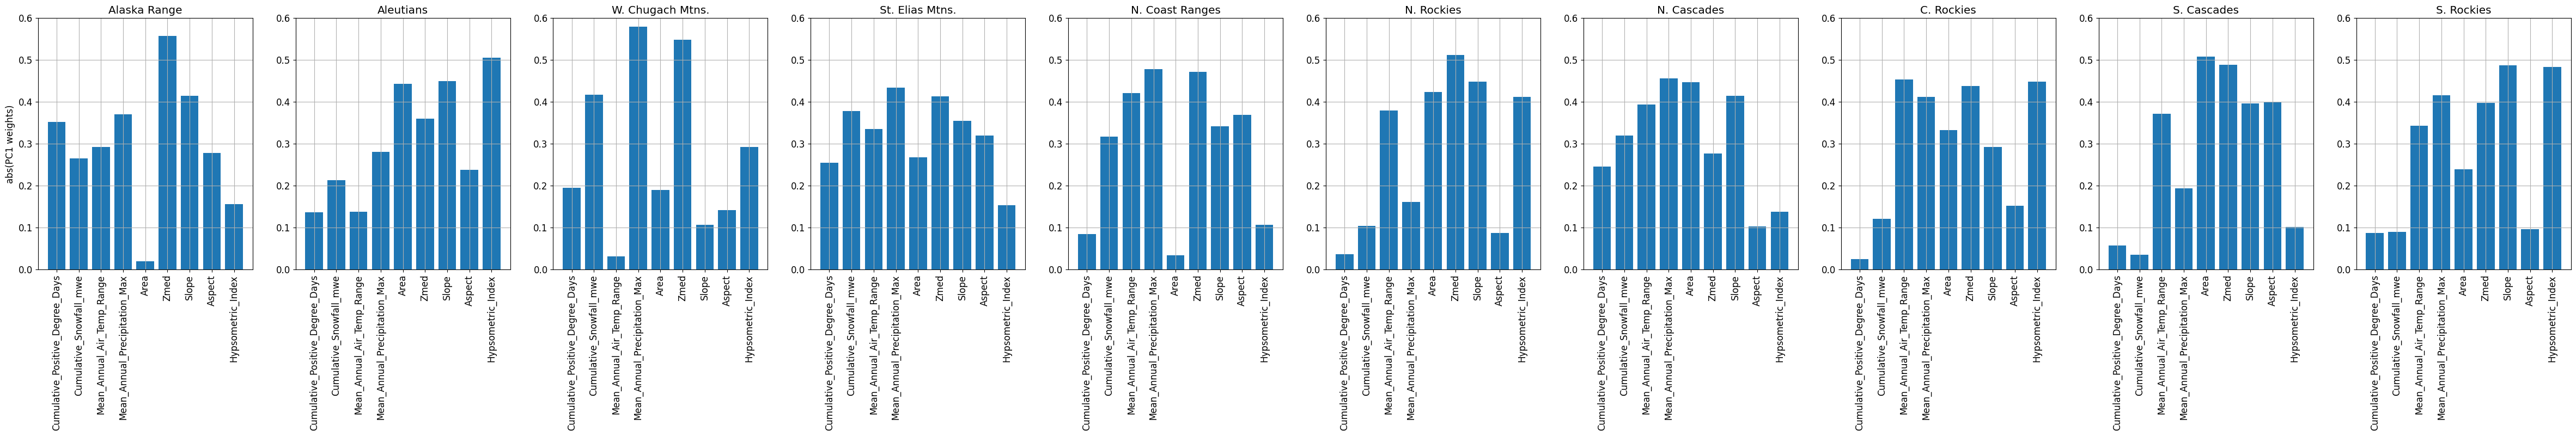

In [31]:
# Define predictor columns
X_columns = ['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe',
            'Mean_Annual_Air_Temp_Range', 'Mean_Annual_Precipitation_Max',
            'Area', 'Zmed', 'Slope', 'Aspect', 'Hypsometric_Index']

# Set up figure
fig, ax = plt.subplots(1, len(unique_subregions), figsize=(6*len(unique_subregions), 6))

# Iterate over subregions
for i, (o1region, o2region) in enumerate(unique_subregions):

    # determine name of subregion
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    print(subregion_name)

    # subset data to sites in subregion
    data_subregion_df = data_df.loc[(data_df['O1Region']==o1region) & (data_df['O2Region']==o2region)]

    # Grab only predictor columns from subregion data
    X = data_subregion_df[X_columns]

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Analyze explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()

    # Grab weights from PC1
    weights = pca.components_[0]

    # Plot weights
    ax[i].bar(np.arange(0, len(X_columns)), np.abs(weights))
    ax[i].set_xticks(np.arange(0, len(X_columns)))
    ax[i].set_xticklabels(X_columns, rotation=90)
    ax[i].set_title(subregion_name)
    if i==0:
        ax[i].set_ylabel('abs(PC1 weights)')
    ax[i].set_ylim(0, 0.6)
    ax[i].grid()

plt.show()


In [30]:
np.abs(weights)

array([0.0863803 , 0.08943341, 0.34298607, 0.4149493 , 0.23827886,
       0.39707486, 0.48703467, 0.09605598, 0.48357312])